## Goals: Training the *Final* Models

This notebook trains the model on the full *baseline_dataset* for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic *regions*.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.

In [27]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.custom_models import VotingRandomForestQuantileRegressor
from src.utils.model import split_dataset, compare_models_per_station

##### Constants :
- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.

In [28]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_TRANSFORMS = [
    "remove_geneve_station",
    "full_pca",
    # "snow_index",
    "one_hot_encode_month_season",
    "scale_train_waterflows",
]

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)


MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4

FINAL_MODELS = [
                # "qrf_bagging",
                "qrf_voting",
                "qrf",
                # "gbr"
                ]

qrf = {}
qrf_bagging = {}
qrf_voting = {}
gbr = {}

COLUMNS_TO_DROP = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]


### 2. Data Loading
Load in the baseline datasets, create the directory to save models.

In [29]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target

In [30]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]


### 2. Models training
#### a. QRF Bagging

In [31]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

- **Data Preparation:**  
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).


In [32]:
if "qrf_bagging" in FINAL_MODELS:

    print("Training qrf_bagging")

    initial_model = RandomForestQuantileRegressor(n_estimators= 45, min_samples_split= 2, min_samples_leaf= 9, max_features= None, max_depth= 30)
    train_mapie_svm, val_mapie_svm, val_temporal  = split_dataset(dataset_train, 0.75, TIME_VALIDATION)    

    X_train_mapie_svm = train_mapie_svm.drop(columns=COLUMNS_TO_DROP)
    X_train_mapie_svm = X_train_mapie_svm.drop(columns=["station_code"])
    print(len(X_train_mapie_svm.columns))
    y_train_mapie_svm = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_mapie_svm[i] = train_mapie_svm[f"water_flow_week{i+1}"]

    X_val = val_mapie_svm.drop(columns=COLUMNS_TO_DROP)
    X_val = X_val.drop(columns=["station_code"])
    y_val = {}
    y_val[0] = val_mapie_svm["water_flow_week1"]
    for i in range(1, NUMBER_OF_WEEK):
        y_val[i] = val_mapie_svm[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        # Initialize and train Model
        qrf_bagging[i] = BaggingRegressor(estimator=initial_model, n_estimators=3, random_state=0)
        qrf_bagging[i].fit(X_train_mapie_svm, y_train_mapie_svm[i])
        
        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/qrf_bagging_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_bagging[i], model_path)


#### b. QRF Voting


In [ ]:

if "qrf_voting" in FINAL_MODELS:
    print("Training qrf_voting")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        qrf_voting[i] = VotingRandomForestQuantileRegressor()
        qrf_voting[i].fit(X_train, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_voting_quantile{time}_week_{i}.pkl"
        joblib.dump(qrf_voting[i], model_path)


Training qrf_voting
Training week 0
Training for variant full_model_remove_station_identication
Training on 27702 samples
Training for variant france_remove_station_identication
Training on 21141 samples
Training for variant brazil_remove_station_identication
Training on 6561 samples
Training week 1
Training for variant full_model_remove_station_identication
Training on 27702 samples
Training for variant france_remove_station_identication
Training on 21141 samples


#### c. GradientBoostingRegressor

In [ ]:
if "gbr" in FINAL_MODELS:
    gbr = {}
    X_train_gbr = X_train.drop(columns=["station_code"])
    print("Training GradientBoostingRegressor")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        gbr[i] = {}
        common_params = dict(
            learning_rate=0.05,
            n_estimators=200,
            max_depth=2,
            min_samples_leaf=9,
            min_samples_split=9,
        )
        
        for alpha in [0.05, 0.5, 0.95]:
            print(f"Training quantile {alpha}")
            gbr_model = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
            key = "lower" if alpha == 0.05 else "median" if alpha == 0.5 else "upper"
            gbr[i][key] = gbr_model.fit(X_train_gbr, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gbr_quantile_{time}_week_{i}.pkl"
        joblib.dump(gbr[i], model_path)

Training GradientBoostingRegressor
Training week 0
Training quantile 0.05
Training quantile 0.5
Training quantile 0.95
Training week 1
Training quantile 0.05
Training quantile 0.5
Training quantile 0.95
Training week 2
Training quantile 0.05
Training quantile 0.5
Training quantile 0.95
Training week 3
Training quantile 0.05
Training quantile 0.5
Training quantile 0.95


#### d. QRF 

In [ ]:
X_train_qrf = X_train.drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        # n_estimators= 45, min_samples_split= 2, min_samples_leaf= 9, max_features= None, max_depth= 30
        # 'model__n_estimators': 60, 'model__min_samples_split': 20
        # n_estimators=60, min_samples_split=5, min_samples_leaf=15, max_features=None, max_depth=20, bootstrap=True
        qrf[i] = RandomForestQuantileRegressor(n_estimators=60, min_samples_split=5, min_samples_leaf=15, max_features=None, max_depth=20, bootstrap=True)
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [ ]:
preds = {}

location_confidences = [1.9, 1.95, 2]

for confidence_value in location_confidences:
    preds[confidence_value] = {}
    for i in range(NUMBER_OF_WEEK):
        qrf_voting[i].adjust_weights(location_confidence = confidence_value)
        preds[confidence_value][i] = {}
        preds[confidence_value][i] = qrf_voting[i].predict(X_train)
        preds[confidence_value][i]["y_true"] = y_train[i]

Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_

Using 1.9 location confidence
Using 1.95 location confidence
Using 2 location confidence


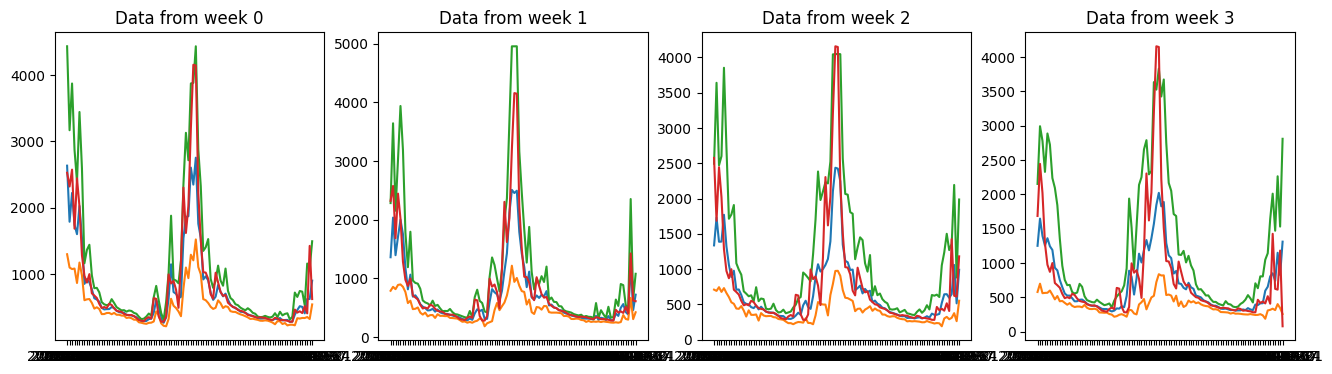

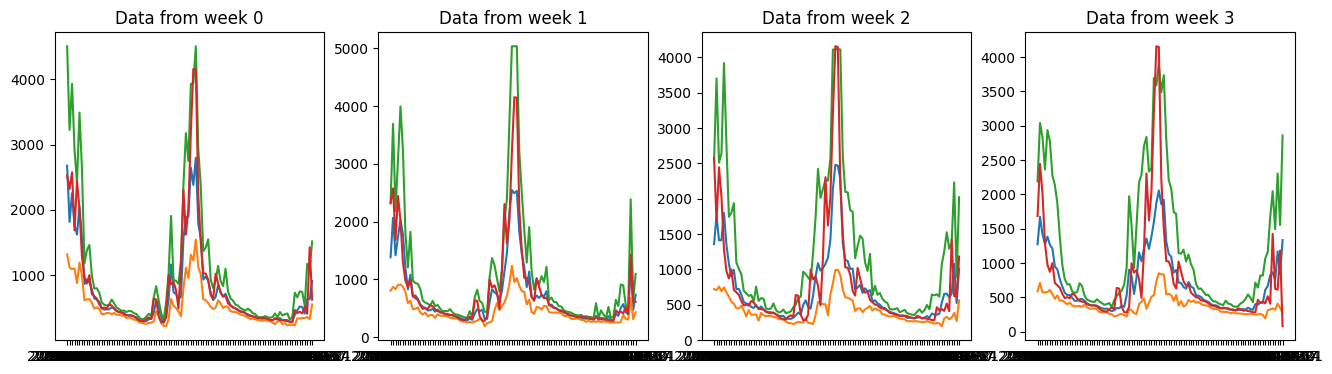

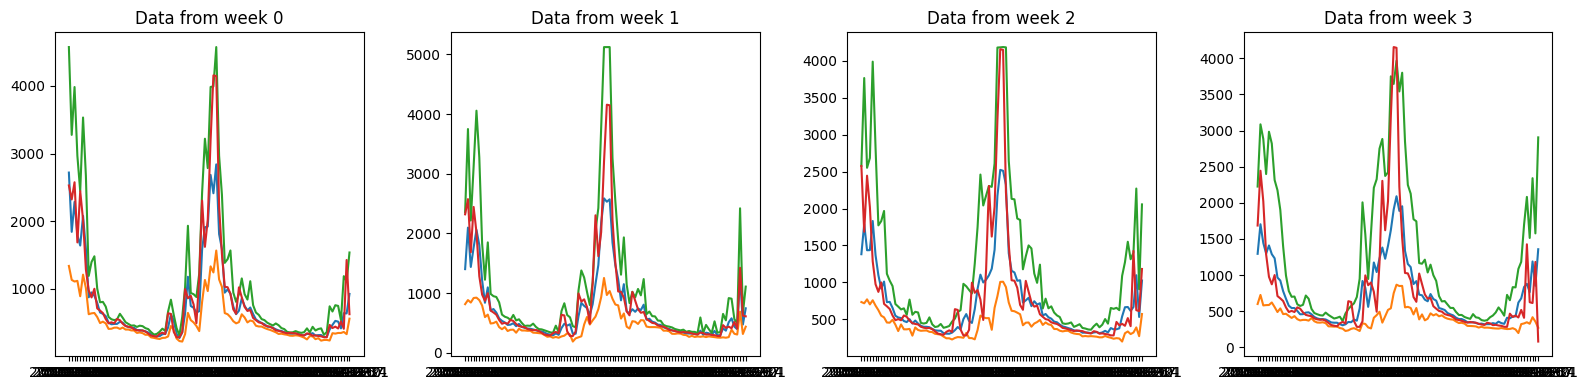

In [ ]:
import matplotlib.pyplot as plt


for confidence_value in location_confidences:

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    print(f"Using {confidence_value} location confidence")

    for i in range(NUMBER_OF_WEEK):
        axes[i].plot(preds[confidence_value][i][27600:27700])
        axes[i].set_title(f"Data from week {i}")

plt.tight_layout()  
plt.show()

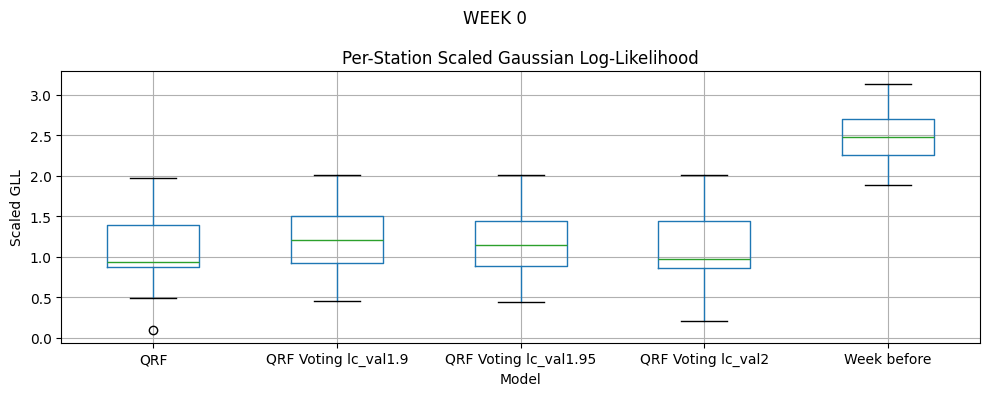

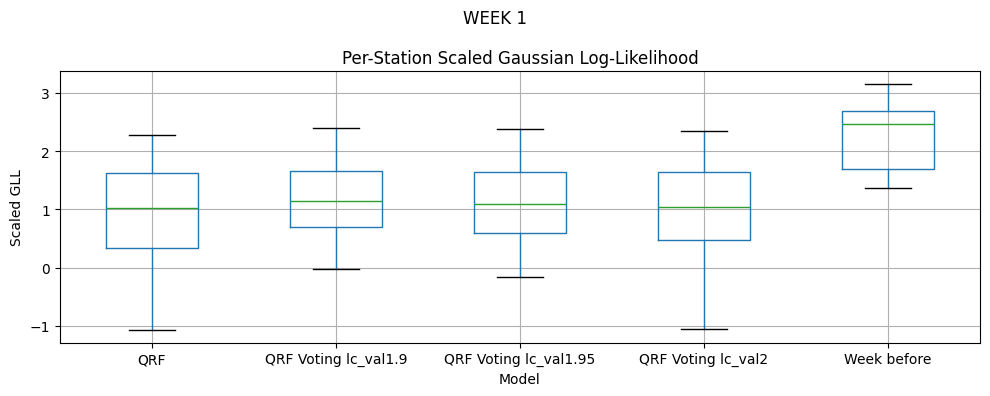

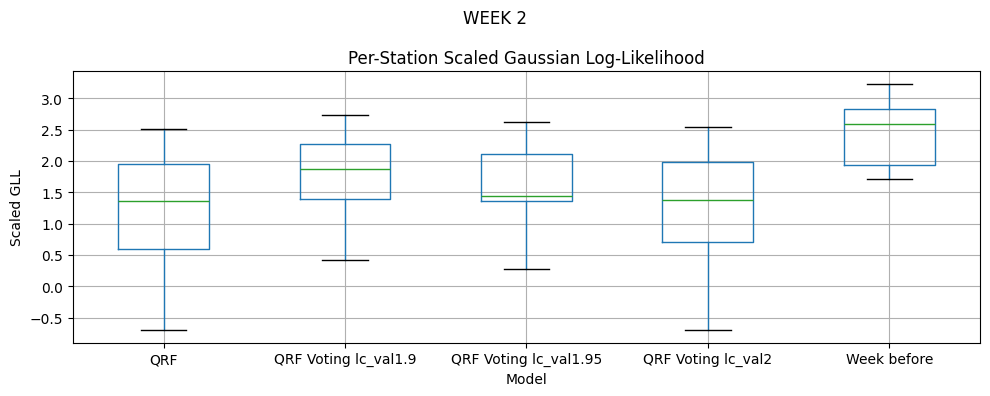

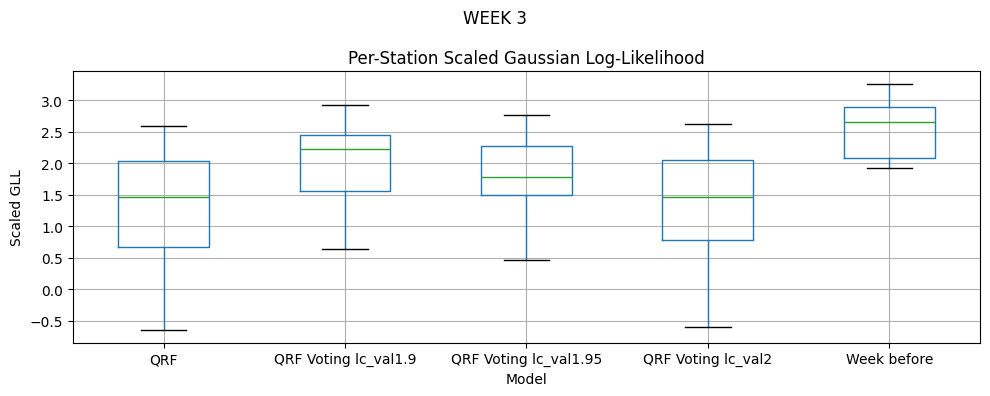

In [ ]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append({"model": "Week before", "prediction": baseline_day_before, "dataset":"train", "stations": y_train_stations, "prediction_interval": None})
    
    if "qrf_bagging" in FINAL_MODELS:
        y_pred_qrf_bagging = np.mean([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], axis=0)
        y_pis_qrf_bagging = np.stack([np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.05, axis=0),
                                    np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.95, axis=0)], axis=1)

        predictions.append({"model": "QRF bagging",
                                "prediction": y_pred_qrf_bagging,
                                "dataset":"train",
                                "stations": y_train_stations,
                                "prediction_interval": y_pis_qrf_bagging})
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(X_train_eval, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA/2, 1-ALPHA/2])
        predictions.append({"model": "QRF",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
    if "qrf_voting" in FINAL_MODELS:

        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_qrf_voting = y_preds_voting["mean"]
            y_pis_qrf_voting = np.stack([y_preds_voting["lower"],
                                        y_preds_voting["upper"]], axis=1)

            predictions.append({"model": f"QRF Voting lc_val{confidence_value}",
                                    "prediction": y_pred_qrf_voting,
                                    "dataset":"train",
                                    "stations": y_train_stations,
                                    "prediction_interval": y_pis_qrf_voting})
    
    if "gbr" in FINAL_MODELS:
        X_train_gbr = X_train.drop(columns=["station_code"])
        y_pred_qrf = gbr[i]["median"].predict(X_train_eval)
        y_pis_qrf = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        predictions.append({"model": "GBR",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood" ,
        title = f"WEEK {i}")

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [ ]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "qrf_bagging" in FINAL_MODELS:
        y_pred_qrf_bagging = np.mean([est.predict(X_train_eval, quantiles="mean") for est in qrf_bagging[i].estimators_], axis=0)
        y_pis_qrf_bagging = np.mean(np.stack(
                [
                    [
                        est.predict(X_train_eval, quantiles=[ALPHA / 2])
                        for est in qrf_bagging[i].estimators_
                    ],
                    [
                        est.predict(X_train_eval, quantiles=[ 1 - ALPHA / 2])
                        for est in qrf_bagging[i].estimators_
                    ]
                ],
                axis=1,
            ), axis=0)
        print(y_pred_qrf_bagging.shape)
        print(y_pis_qrf_bagging.shape)
        coverage = (y_train[i].values >= y_pis_qrf_bagging[0,:]) & (y_train[i].values <= y_pis_qrf_bagging[1,:])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    
    if "gbr" in FINAL_MODELS:
        y_pred_gbr = gbr[i]["median"].predict(X_train_eval)
        y_pis_gbr = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(X_train_eval, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA/2, 1-ALPHA/2])
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
        
    if "qrf_voting" in FINAL_MODELS:
        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_gbr = y_preds_voting["mean"]
            y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
            coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
            print(f"QRF coverage of the prediction interval for week {i}, lc_val {confidence_value}: {coverage.mean()}")

QRF coverage of the prediction interval for week 0: 0.9732510288065843
QRF coverage of the prediction interval for week 0, lc_val 1.9: 0.9544076239982673
QRF coverage of the prediction interval for week 0, lc_val 1.95: 0.9603277741679301
QRF coverage of the prediction interval for week 0, lc_val 2: 0.9669337953938344
QRF coverage of the prediction interval for week 1: 0.9729983394700744
QRF coverage of the prediction interval for week 1, lc_val 1.9: 0.9512670565302144
QRF coverage of the prediction interval for week 1, lc_val 1.95: 0.9592809183452459
QRF coverage of the prediction interval for week 1, lc_val 2: 0.9683416359829615
QRF coverage of the prediction interval for week 2: 0.9715904988809472
QRF coverage of the prediction interval for week 2, lc_val 1.9: 0.9472601256226987
QRF coverage of the prediction interval for week 2, lc_val 1.95: 0.957909176232763
QRF coverage of the prediction interval for week 2, lc_val 2: 0.9658508410945058
QRF coverage of the prediction interval for 